In [10]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
import matplotlib.pyplot as plt
import glob
import scipy.io as sio
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [11]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [12]:
# df = pd.read_csv('D:/ITI/Machine Learning/AFLW2000.csv')

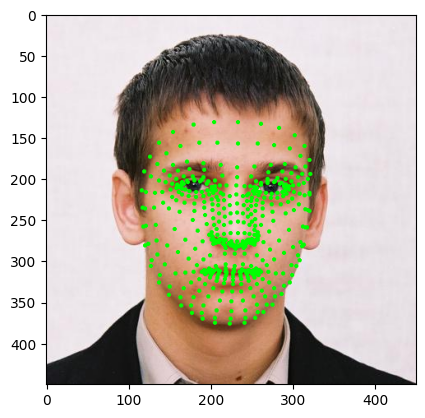

In [13]:
# choosing random image
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    # image = cv2.imread('/AFLW2000/'+random_file+'.jpg')
    image = cv2.imread(r'D:/ITI/Machine Learning/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    #   cv2_imshow(image)
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

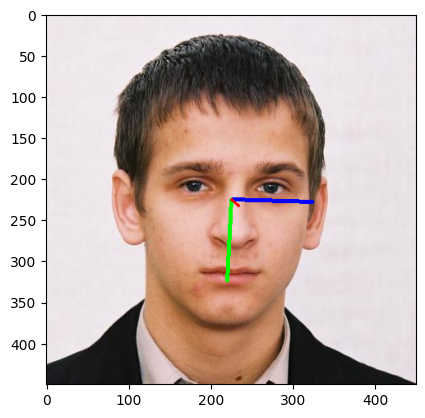

In [14]:
image = cv2.imread(r'D:/ITI/Machine Learning/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat(r'D:/ITI/Machine Learning/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
plt.imshow(draw_axis(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),pitch,yaw,roll))

In [15]:
image_files = glob.glob('D:/ITI/Machine Learning/AFLW2000/*.jpg')
dfs = []

for image in image_files:
    dfn = cv2.imread(image)
    dfs.append(dfn)


In [16]:
mat_files = glob.glob('D:/ITI/Machine Learning/AFLW2000/*.mat')
dfs2 = []

for mat in mat_files:
    dfn2 = sio.loadmat(mat)
    dfs2.append(dfn2)

In [17]:
len(dfs), len(dfs2)

(2000, 2000)

In [19]:
#inserting images into mediapipe to get the landmarks
faceModule = mediapipe.solutions.face_mesh.FaceMesh(static_image_mode=True)

all_landmarks = []
all_mat = []
for i in range(len(dfs)):
    results = faceModule.process(cv2.cvtColor(dfs[i], cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
        for face in results.multi_face_landmarks:
            landmarks = []
            nose = face.landmark[4]
            chin = face.landmark[152]
            euclidan = np.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
            for landmark in face.landmark:
                relative_x = int(((landmark.x - nose.x)/euclidan) * dfs[i].shape[1])
                relative_y = int(((landmark.y - nose.y)/euclidan) * dfs[i].shape[0])
                landmarks.extend([relative_x,relative_y])
        all_landmarks.append(landmarks)
        m = dfs2[i]["Pose_Para"][0][:3]
        pitch = m[0]
        yaw = m[1]
        roll = m[2]
        all_mat.append([pitch,yaw,roll])
    

In [20]:
len(all_landmarks), len(all_mat)

(1853, 1853)

In [21]:
all_landmarks = np.array(all_landmarks)
all_mat = np.array(all_mat)
#naming the columns x1, y2, x2, y2, ...
columns = []
for i in range(1,all_landmarks.shape[1]//2+1):
    columns.append('x'+str(i))
    columns.append('y'+str(i))
df = pd.DataFrame(all_landmarks, columns=columns)
df['pitch'] = all_mat[:,0]
df['yaw'] = all_mat[:,1]
df['roll'] = all_mat[:,2]
df

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,y465,x466,y466,x467,y467,x468,y468,pitch,yaw,roll
0,-10,143,-2,40,-1,56,-23,-127,0,0,...,-279,110,-263,381,-326,404,-342,-0.399231,0.018227,0.085676
1,60,154,3,36,78,79,47,-75,0,0,...,-154,200,-146,399,-181,421,-193,0.470065,1.189533,0.300959
2,-15,132,0,36,-13,60,-44,-92,0,0,...,-198,30,-188,219,-231,237,-245,-0.184650,0.881137,-0.236852
3,93,125,17,35,61,46,-38,-104,0,0,...,-280,63,-262,295,-401,311,-426,-0.175379,0.299208,-0.373374
4,39,152,8,36,20,71,-37,-76,0,0,...,-173,31,-165,206,-238,222,-245,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,-44,172,-5,41,-37,72,-53,-106,0,0,...,-234,10,-222,210,-287,225,-298,-0.306358,-0.283822,0.038554
1849,-51,154,-6,40,-40,64,-47,-111,0,0,...,-242,13,-229,191,-285,207,-304,-0.367547,-0.429723,0.122791
1850,-45,136,-10,33,-30,69,-12,-82,0,0,...,-138,76,-134,243,-122,261,-137,-0.156035,0.567114,-0.108536
1851,-25,163,-6,43,-13,70,-28,-125,0,0,...,-262,101,-249,370,-293,393,-310,-0.197102,-0.070430,0.105118


In [22]:
df.to_csv('D:/ITI/Machine Learning/AFLW2000.csv', index=False)

In [23]:
# #Splitting the data into training ,testing and validation
# X_roll = X_pitch = X_yaw= df.drop(['pitch','yaw','roll'], axis=1)
# y_roll = df['roll']
# y_pitch = df['pitch']
# y_yaw = df['yaw']
# X_roll_train, X_roll_test, y_roll_train, y_roll_test = train_test_split(X_roll, y_roll, test_size=0.2, random_state=42)
# X_pitch_train, X_pitch_test, y_pitch_train, y_pitch_test = train_test_split(X_pitch, y_pitch, test_size=0.2, random_state=42)
# X_yaw_train, X_yaw_test, y_yaw_train, y_yaw_test = train_test_split(X_yaw, y_yaw, test_size=0.2, random_state=42)
# X_roll_test, X_roll_val, y_roll_test, y_roll_val = train_test_split(X_roll_test, y_roll_test, test_size=0.5, random_state=42)
# X_pitch_test, X_pitch_val, y_pitch_test, y_pitch_val = train_test_split(X_pitch_test, y_pitch_test, test_size=0.5, random_state=42)
# X_yaw_test, X_yaw_val, y_yaw_test, y_yaw_val = train_test_split(X_yaw_test, y_yaw_test, test_size=0.5, random_state=42)

In [24]:
#Splitting the data into training ,testing and validation
X= df.drop(['pitch','yaw','roll'], axis=1)
Y= df[['pitch','yaw','roll']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

y_pitch_train = y_train['pitch']
y_yaw_train = y_train['yaw']
y_roll_train = y_train['roll']
y_pitch_val = y_val['pitch']
y_yaw_val = y_val['yaw']
y_roll_val = y_val['roll']

In [25]:
# model1 = joblib.load('model_3r_static.pkl')
# model2 = joblib.load('model_3p_static.pkl')
# model3 = joblib.load('model_3y_static.pkl')

In [26]:
model1 = SVR()
model2 = SVR()
model3 = SVR()
model1.fit(X_train, y_roll_train)
model2.fit(X_train, y_pitch_train)
model3.fit(X_train, y_yaw_train)


SVR()

In [27]:
# xg_parameters = {'n_estimators': np.arange(7,15,2),'max_depth': np.arange(1,10,2),'learning_rate': np.arange(0.5,1,0.2)}
# # grid search pitch
# xg = XGBRegressor(random_state=0,verbosity = 0)
# model1 = GridSearchCV(estimator = xg,param_grid = xg_parameters)
# model1.fit(X_pitch_train, y_pitch_train)
# xg_pitch = model1.best_estimator_
# print(xg_pitch)
# print("Train Error: ",mean_squared_error(xg_pitch.predict(X_pitch_train),y_pitch_train))
# print("Validation Error: ",mean_squared_error(xg_pitch.predict(X_pitch_val),y_pitch_val))

In [28]:

# # grid search yaw
# xg = XGBRegressor(random_state=0,verbosity = 0)
# model2 = GridSearchCV(estimator = xg,param_grid = xg_parameters)
# model2.fit(X_train, y_yaw_train)
# model2_best = model2.best_estimator_
# print(model2_best)
# print("Train Error: ",mean_squared_error(model2.predict(X_train),y_yaw_train))
# print("Validation Error: ",mean_squared_error(model2.predict(X_val),y_yaw_val))

In [29]:

# # grid search roll
# xg = XGBRegressor(random_state=0,verbosity = 0)
# model3 = GridSearchCV(estimator = xg,param_grid = xg_parameters)
# model3.fit(X_train, y_roll_train)
# model3_best = model2.best_estimator_
# print(model3_best)
# print("Train Error: ",mean_squared_error(model3.predict(X_train),y_roll_train))
# print("Validation Error: ",mean_squared_error(model3.predict(X_val),y_roll_val))

In [30]:
#testing the model
y_roll_pred = model1.predict(X_val)
y_pitch_pred = model2.predict(X_val)
y_yaw_pred = model3.predict(X_val)
# calculating score
score1 = model1.score(X_val, y_roll_val)
score2 = model2.score(X_val, y_pitch_val)
score3 = model3.score(X_val, y_yaw_val)
score1, score2, score3

(0.9213779502629689, 0.8088708501286903, 0.9647380739303785)

In [31]:
#calculating mean squared error
mse1 = mean_squared_error(y_roll_val, y_roll_pred)
mse2 = mean_squared_error(y_pitch_val, y_pitch_pred)
mse3 = mean_squared_error(y_yaw_val, y_yaw_pred)
mse1, mse2, mse3

(0.007688366255628453, 0.012304402345978434, 0.008946670213018055)

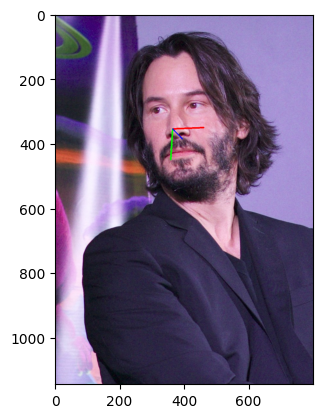

In [34]:
img1 = cv2.imread('Keanu_Reeves.jpg')
results = faceModule.process(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
if results.multi_face_landmarks != None: 
    for face in results.multi_face_landmarks:
        landmarks = []
        nose = face.landmark[4]
        chin = face.landmark[152]
        euclidan = math.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
        for landmark in face.landmark:
            relative_x = int(((landmark.x - nose.x)/euclidan))
            relative_y = int(((landmark.y - nose.y)/euclidan))
            landmarks.extend([relative_x,relative_y])
    landmarks = np.array(landmarks).reshape(1,-1)
    roll = model1.predict(landmarks)
    pitch = model2.predict(landmarks)
    yaw = model3.predict(landmarks)
    frame = draw_axis(img1,pitch,yaw,roll, tdx=(nose.x*img1.shape[1]), tdy=(nose.y*img1.shape[0]))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))



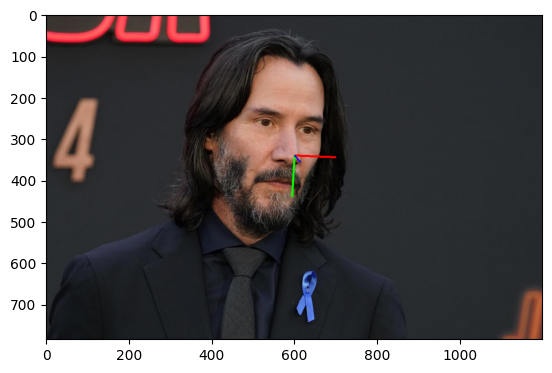

In [36]:
img2 = cv2.imread('Keanu_Reeves2.jpeg')
results = faceModule.process(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
if results.multi_face_landmarks != None: 
    for face in results.multi_face_landmarks:
        landmarks = []
        nose = face.landmark[4]
        chin = face.landmark[152]
        euclidan = math.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
        for landmark in face.landmark:
            relative_x = int(((landmark.x - nose.x)/euclidan) * img2.shape[1])
            relative_y = int(((landmark.y - nose.y)/euclidan) * img2.shape[0])
            landmarks.extend([relative_x,relative_y])
landmarks = np.array(landmarks).reshape(1,-1)
roll = model1.predict(landmarks)
pitch = model2.predict(landmarks)
yaw = model3.predict(landmarks)
frame = draw_axis(img2,pitch,yaw,roll, tdx=(nose.x*img2.shape[1]), tdy=(nose.y*img2.shape[0]))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))



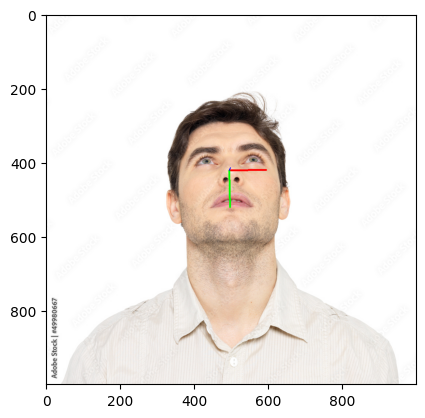

In [37]:
img3 = cv2.imread('up.jpg')
results = faceModule.process(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
if results.multi_face_landmarks != None: 
    for face in results.multi_face_landmarks:
        landmarks = []
        nose = face.landmark[4]
        chin = face.landmark[152]
        euclidan = math.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
        for landmark in face.landmark:
            relative_x = int(((landmark.x - nose.x)/euclidan) * img3.shape[1])
            relative_y = int(((landmark.y - nose.y)/euclidan) * img3.shape[0])
            landmarks.extend([relative_x,relative_y])
landmarks = np.array(landmarks).reshape(1,-1)
roll = model1.predict(landmarks)
pitch = model2.predict(landmarks)
yaw = model3.predict(landmarks)
frame = draw_axis(img3,pitch,yaw,roll, tdx=(nose.x*img3.shape[1]), tdy=(nose.y*img3.shape[0]))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))



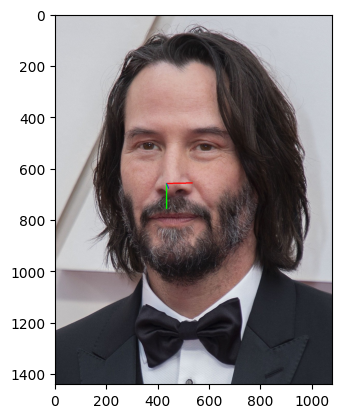

In [39]:
img4 = cv2.imread('Keanu_Reda.jpg')
results = faceModule.process(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
if results.multi_face_landmarks != None: 
    for face in results.multi_face_landmarks:
        landmarks = []
        nose = face.landmark[4]
        chin = face.landmark[152]
        euclidan = math.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
        for landmark in face.landmark:
            relative_x = int(((landmark.x - nose.x)/euclidan) * img4.shape[1])
            relative_y = int(((landmark.y - nose.y)/euclidan) * img4.shape[0])
            landmarks.extend([relative_x,relative_y])
landmarks = np.array(landmarks).reshape(1,-1)
roll = model1.predict(landmarks)
pitch = model2.predict(landmarks)
yaw = model3.predict(landmarks)
frame = draw_axis(img4,pitch,yaw,roll, tdx=(nose.x*img4.shape[1]), tdy=(nose.y*img4.shape[0]))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))



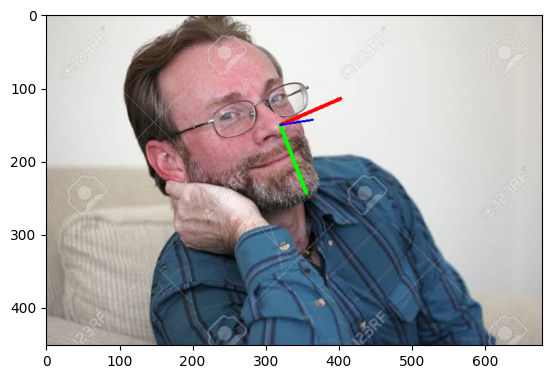

In [40]:
img5 = cv2.imread('Shata2.jpeg')
results = faceModule.process(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
if results.multi_face_landmarks != None: 
    for face in results.multi_face_landmarks:
        landmarks = []
        nose = face.landmark[4]
        chin = face.landmark[152]
        euclidan = math.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
        for landmark in face.landmark:
            relative_x = int(((landmark.x - nose.x)/euclidan) * img5.shape[1])
            relative_y = int(((landmark.y - nose.y)/euclidan) * img5.shape[0])
            landmarks.extend([relative_x,relative_y])
landmarks = np.array(landmarks).reshape(1,-1)
roll = model1.predict(landmarks)
pitch = model2.predict(landmarks)
yaw = model3.predict(landmarks)
frame = draw_axis(img5,pitch,yaw,roll, tdx=(nose.x*img5.shape[1]), tdy=(nose.y*img5.shape[0]))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))



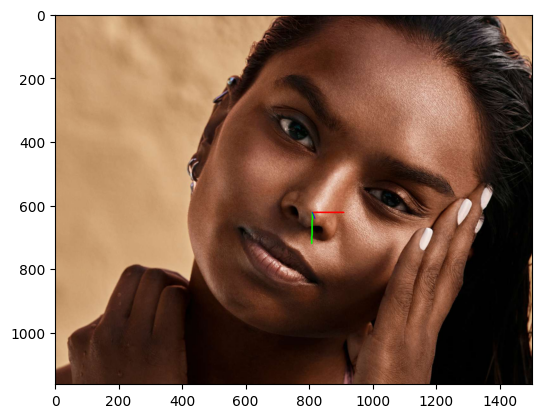

In [42]:
img5 = cv2.imread('Shata.jpeg')
results = faceModule.process(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
if results.multi_face_landmarks != None: 
    for face in results.multi_face_landmarks:
        landmarks = []
        nose = face.landmark[4]
        chin = face.landmark[152]
        euclidan = math.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
        for landmark in face.landmark:
            relative_x = int(((landmark.x - nose.x)/euclidan) * img5.shape[1])
            relative_y = int(((landmark.y - nose.y)/euclidan) * img5.shape[0])
            landmarks.extend([relative_x,relative_y])
landmarks = np.array(landmarks).reshape(1,-1)
roll = model1.predict(landmarks)
pitch = model2.predict(landmarks)
yaw = model3.predict(landmarks)
frame = draw_axis(img5,pitch,yaw,roll, tdx=(nose.x*img5.shape[1]), tdy=(nose.y*img5.shape[0]))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))



In [43]:
# cap = cv2.VideoCapture(0)
# faceModule = mediapipe.solutions.face_mesh
# with faceModule.FaceMesh(static_image_mode=True) as faces:
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             print("Ignoring empty camera frame.")
#             continue
#         results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#         if results.multi_face_landmarks != None: 
#             for face in results.multi_face_landmarks:
#                 for landmark in face.landmark:
#                     relative_x = int(landmark.x * frame.shape[1])
#                     relative_y = int(landmark.y * frame.shape[0])
#                     cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
#         cv2.imshow('MediaPipe FaceMesh', frame)
#         if cv2.waitKey(5) & 0xFF == ord('q'):
#             break
# cap.release()
# cv2.destroyAllWindows()

In [48]:
cap = cv2.VideoCapture('Video1.mp4')
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("video finished.")
            break
        results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
            for face in results.multi_face_landmarks:
                landmarks = []
                nose = face.landmark[4]
                chin = face.landmark[152]
                euclidan = math.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
                for landmark in face.landmark:
                    relative_x = int(((landmark.x - nose.x)/euclidan) * frame.shape[1])
                    relative_y = int(((landmark.y - nose.y)/euclidan) * frame.shape[0])
                    landmarks.extend([relative_x,relative_y])
                    # cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                landmarks = np.array(landmarks).reshape(1,-1)
                roll = model1.predict(landmarks)
                pitch = model2.predict(landmarks)
                yaw = model3.predict(landmarks)
                frame = draw_axis(frame,pitch,yaw,roll, tdx=(nose.x*frame.shape[1]), tdy=(nose.y*frame.shape[0]))
        cv2.imshow('MediaPipe FaceMesh', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

video finished.


In [ ]:
cap = cv2.VideoCapture(0)
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("video finished.")
            break
        results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
            for face in results.multi_face_landmarks:
                landmarks = []
                nose = face.landmark[4]
                chin = face.landmark[152]
                euclidan = math.sqrt((nose.x - chin.x)**2 + (nose.y - chin.y)**2)
                for landmark in face.landmark:
                    relative_x = int(((landmark.x - nose.x)/euclidan) * frame.shape[1])
                    relative_y = int(((landmark.y - nose.y)/euclidan) * frame.shape[0])
                    landmarks.extend([relative_x,relative_y])
                    # cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                landmarks = np.array(landmarks).reshape(1,-1)
                roll = model1.predict(landmarks)
                pitch = model2.predict(landmarks)
                yaw = model3.predict(landmarks)
                frame = draw_axis(frame,pitch,yaw,roll, tdx=(nose.x*frame.shape[1]), tdy=(nose.y*frame.shape[0]))
        cv2.imshow('MediaPipe FaceMesh', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()